<a href="https://colab.research.google.com/github/Gbemi123/GANs-with-MNIST-Fashion-dataset/blob/main/GANs_MNIST_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversial Networks

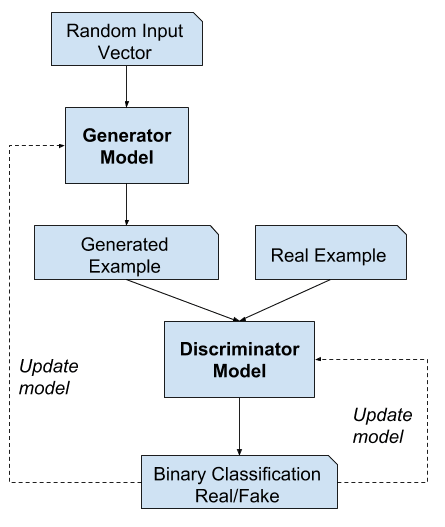

## Import Libraries

In [ ]:
import numpy as np 
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
import torchvision.datasets as datasets
import torchvision
import matplotlib.pyplot as plt 
import PIL.Image as Image
import torch.functional as F
import pandas as  pd
import torchvision.transforms as T
from torchvision.utils import make_grid

## Getting the MNIST Fashion dataset

In [ ]:
transforms= T.Compose(
    [T.ToTensor(), T.Normalize((0.5,), (0.5))]
)

In [ ]:
data_mnist= datasets.FashionMNIST(root='.', train=True, transform=transforms, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
batch_size =32 
train_loader = DataLoader(dataset= data_mnist, batch_size =batch_size, shuffle= True)

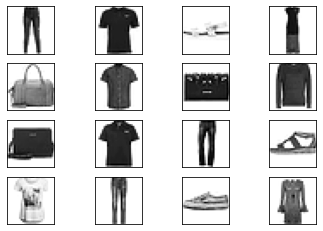

In [ ]:
# Showing the data

real, labels = next(iter(train_loader)) 

for i in range(16):

  ax =plt.subplot(4, 4, i+1)
  plt.imshow(real[i].reshape(28,28), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

## Creating the discriminator model

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat =nn.Flatten()

    self.dis_model=nn.Sequential(
        #1st layer 
        nn.Linear(784, 1024),
        nn.ReLU(), 
        nn.Dropout(0.3), 

        #2nd Layer 
        nn.Linear(1024, 512),
        nn.ReLU(), 
        nn.Dropout(0.3), 

        #3rd Layer
        nn.Linear(512, 256), 
        nn.ReLU(), 
        nn.Dropout(0.3), 
        
        #4th layer 
        nn.Linear(256, 1),
        nn.Sigmoid()


    )


  def forward(self, x):
    
    x=self.flat(x)
    out=self.dis_model(x)

    return out


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminate =Discriminator().to(device)

## Creating the Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
  
    self.gen_model=nn.Sequential(
        #1st layer 
        nn.Linear(100, 256),
        nn.ReLU(), 
        
        #2nd Layer 
        nn.Linear(256, 512),
        nn.ReLU(), 
        
        #3rd Layer
        nn.Linear(512, 1024), 
        nn.ReLU(), 
                
        #4th layer 
        nn.Linear(1024, 784),
        nn.Tanh()
    )


  def forward(self, x):
    
    out=self.gen_model(x)
    out=out.view(x.size(0), 1, 28, 28)

    return out

In [ ]:
generator =Generator().to(device)

## Time to Trainnnn!!!


In [ ]:
lr=0.0001
epochs=50
loss_function =nn.BCELoss()

optim_gen= torch.optim.Adam(generator.parameters(), lr=lr)
optim_dis= torch.optim.Adam(discriminate.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):

  for n, (input_data, labels) in enumerate(train_loader):

    input_data =input_data.to(device)

    # create ones for labels of the discriminator i.e. binary 1 for real 0 for fake 
    input_labels=torch.ones((batch_size,1)).to(device)

    #create noise as the input data for the first instance 

    noise = torch.randn((batch_size, 100)).to(device)
    fake_labels=torch.zeros((batch_size,1)).to(device)

    # Put noise into the generator 
    generated_data =  generator(noise)

    #combine real and fake samples and labels for training

    all_data = torch.cat((input_data, generated_data))
    all_labels= torch.cat((input_labels, fake_labels)) 

    #Training the discriminator
    discriminate.zero_grad()
    
    discriminate_output=discriminate(all_data)
    loss_discrminate = loss_function(discriminate_output, all_labels)

    loss_discrminate.backward()
    optim_dis.step()

    #data for the generator
    noise = torch.randn((batch_size, 100)).to(device)
    
    #Training the generrator
    generator.zero_grad()

    generated_output =generator(noise)
    dis_gen_output=discriminate(generated_output)
    loss_generate=loss_function(dis_gen_output, input_labels)

    loss_generate.backward()
    optim_gen.step()

    #print loss

    if n== batch_size-1:

      print(f'Epoch: {epoch+1} Loss Dis: {loss_discrminate}')
      print(f'Epoch: {epoch+1} Loss Gen: {loss_generate}')


Epoch: 1 Loss Dis: 0.5271233320236206
Epoch: 1 Loss Gen: 0.5575114488601685
Epoch: 2 Loss Dis: 0.061847396194934845
Epoch: 2 Loss Gen: 5.347182273864746
Epoch: 3 Loss Dis: 0.12600818276405334
Epoch: 3 Loss Gen: 4.844777584075928
Epoch: 4 Loss Dis: 0.24686014652252197
Epoch: 4 Loss Gen: 3.8116583824157715
Epoch: 5 Loss Dis: 0.24329225718975067
Epoch: 5 Loss Gen: 2.0552616119384766
Epoch: 6 Loss Dis: 0.26475387811660767
Epoch: 6 Loss Gen: 2.373274803161621
Epoch: 7 Loss Dis: 0.29226529598236084
Epoch: 7 Loss Gen: 2.437760829925537
Epoch: 8 Loss Dis: 0.4970649778842926
Epoch: 8 Loss Gen: 1.9807929992675781
Epoch: 9 Loss Dis: 0.47054654359817505
Epoch: 9 Loss Gen: 1.685510516166687
Epoch: 10 Loss Dis: 0.6012234687805176
Epoch: 10 Loss Gen: 1.8938716650009155
Epoch: 11 Loss Dis: 0.45316946506500244
Epoch: 11 Loss Gen: 1.349173665046692
Epoch: 12 Loss Dis: 0.6224103569984436
Epoch: 12 Loss Gen: 1.2399795055389404
Epoch: 13 Loss Dis: 0.5013935565948486
Epoch: 13 Loss Gen: 1.3462350368499756
E

## Testing to see if it works 

In [ ]:
noise= torch.randn((batch_size , 100)).to(device)
generated_data = generator(noise)




# plotting results

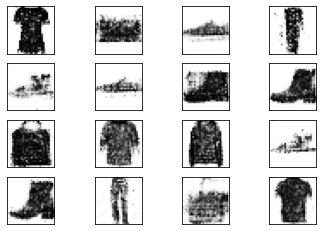

In [ ]:
generated_data = generated_data.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_data[i].squeeze(), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
torch.save(generator, '/content/drive/MyDrive/Colab Notebooks/PERSONAL PROJECTS/mnist_fashion_generator.pth')